# Test MDRNN Training by Overfitting

In this notebook, we will try to train the MDRNN on a single example to see if we can get it to overfit. Hopefully we can debug the model a bit this way.

### First Import the Model and Tensorflow

In [44]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
# little path hack to get robojam from one directory up in the filesystem.
from context import * # imports robojam
# import robojam # alternatively do this.
import tensorflow as tf
import h5py
import numpy as np
import random
import time
import pandas as pd
%matplotlib inline

In [8]:
# Training Hyperparameters:
SEQ_LEN = 256
BATCH_SIZE = 1
HIDDEN_UNITS = 256
LAYERS = 3
MIXES = 16
EPOCHS = 1000

# These settings train for 2.1 epochs which is pretty good!
SEED = 2345  # 2345 seems to be good.

random.seed(SEED)
np.random.seed(SEED)
# tf.set_random_seed(5791)  # only works for current graph.

In [27]:
microjam_data_file_name = "../datasets/TinyPerformanceCorpus.h5"
metatone_data_file_name = "../datasets/MetatoneTinyPerformanceRecords.h5"

with h5py.File(microjam_data_file_name, 'r') as data_file:
    microjam_corpus = data_file['total_performances'][:]
with h5py.File(metatone_data_file_name, 'r') as data_file:
    metatone_corpus = data_file['total_performances'][:]

sequence_loader = robojam.sample_data.SequenceDataLoader(num_steps=SEQ_LEN + 1, batch_size=BATCH_SIZE, corpus=microjam_corpus)
examples = sequence_loader.non_overlapping_examples()
overfit_datum = examples[1]  # picked a sample
start_point = overfit_datum[0]
print("Start Point:", start_point)

Total training examples: 172003
Done initialising loader.
Total non-overlapping examples: 670
Start Point: [ 0.25        0.68000001  0.017413  ]


In [33]:
b = sequence_loader.next_epoch()
print(b.shape)
print(overfit_datum.shape)
only_one_batch = b[1]
print(only_one_batch.shape)

(172003, 1, 257, 3)
(257, 3)
(1, 257, 3)


In [36]:
np.array([only_one_batch])

(1, 1, 257, 3)

In [28]:
print("Loading Network")
# Setup network
net = robojam.MixtureRNN(mode=robojam.NET_MODE_TRAIN, 
                         n_hidden_units=HIDDEN_UNITS, 
                         n_mixtures=MIXES, 
                         batch_size=BATCH_SIZE, 
                         sequence_length=SEQ_LEN, 
                         n_layers=LAYERS)

Loading Network
INFO:tensorflow:Loading Training Operations


INFO:tensorflow:Loading Training Operations


INFO:tensorflow:done initialising: mdrnn-2d-1d-3layers-256units-16mixtures vars: 1353872


INFO:tensorflow:done initialising: mdrnn-2d-1d-3layers-256units-16mixtures vars: 1353872


In [52]:
# load metatone data and train MDRNN from that.
print("Training Network:", net.model_name())
# # Train
# losses = net.train(sequence_loader, EPOCHS, saving=True)
# print(losses)

"""Train the network for the a number of epochs."""
num_epochs = 300
tf.logging.info("going to train: %s", net.model_name())
start_time = time.time()
training_losses = []

step = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(num_epochs):
        batches = np.array([only_one_batch])
        # try training, stop if there is a value error (NaN in loss).
        try:
            epoch_average_loss, step = net.train_epoch(batches, sess)
        except ValueError as err:
            tf.logging.info("training was aborted due to value error at global_step %d, epoch %d", step, i)
            tf.logging.info(err.args)
            break
        training_losses.append(epoch_average_loss)
        print("trained epoch %d of %d. Loss was: %f" % (i, num_epochs, epoch_average_loss), end="\r")
#     if saving:
#         # Save finished model separately.
#         tf.logging.info('saving model %s.', net.model_name())
#         net.saver.save(sess, MODEL_DIR + net.model_name())
tf.logging.info("took %d seconds to train.", (time.time() - start_time))
training_losses

print("Done")

Training Network: mdrnn-2d-1d-3layers-256units-16mixtures
INFO:tensorflow:going to train: mdrnn-2d-1d-3layers-256units-16mixtures


INFO:tensorflow:going to train: mdrnn-2d-1d-3layers-256units-16mixtures


INFO:tensorflow:took 293 seconds to train.979


INFO:tensorflow:took 293 seconds to train.


Done


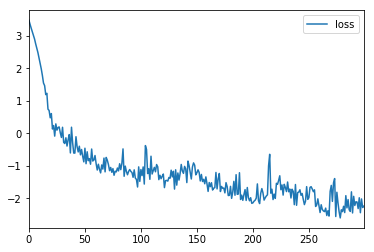

In [53]:
df = pd.DataFrame({"loss":training_losses})
df.plot()